# Práctica: Precios de Casas en California.

El objetivo de esta practica es trabajar con datos antes de inyectarlos a un modelo de aprendizaje automático.
Vamos a trabajar con un fichero que contiene un censo de casas del estado de California. Incluye, entre otras, características como la población, los ingresos medios, y el precio mediano de las casas en diferentes "distritos" de California.

El modelo de aprendizaje automático deberá aprender de los datos de dentrada y ser capaz de predecir el precio mediano en un distrito de California conocidas sus características.

Podemos clasificar el problema como aprendizaje supervisado, ya que los datos conocidos incluyen la variable objetivo a predecir. Además es un problema de regresión puesto que el valor que devolverá el modelo puede tomar cualquier valor dentro de un intervalo.

## 1. Preparamos el entorno

Definimos algunos requisitos para las librerías usadas y las versiones de Python para no tener problemas de compatibilidad con las funciones que vamos a usar.
Generamos un directorio donde guardar las imágenes que iremos generando durante el `Notebook`. Este directorio estará un nivel por encima del fichero `.ipynb` y alojará las imágenescon extensión `.png`

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
#PROJECT_ROOT_DIR = os.getcwd()
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.abspath(os.path.join(PROJECT_ROOT_DIR, "Imagenes"))
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Imagenes")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, images_path = IMAGES_PATH):
    if not os.path.isdir(images_path):
        os.makedirs(images_path)
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Obtener los datos de entrada

### 2.1. Descarga de datos

Vamos a descargar el fichero `housing.tgz` del repositorio de [Aurélien Géron](https://github.com/ageron/handson-ml3) y usaremos una función para descomprimirlo y almacenarlo con extensión `.csv`

In [12]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join(PROJECT_ROOT_DIR,"Archivos", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

 LLamamos a la función que creará una nueva carpeta `\Archivos\housing\` a la misma altura que `\Imagenes\` dentro del árbol de directorios, donde almacenará `housing.tgz` y su equivalente `housing.csv` descomprimido. 

In [13]:
fetch_housing_data()

/var/folders/5k/9l_057d96278gk0jt1qt_wkc0000gn/T/ipykernel_23425/2869986572.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


Cargamos el fichero en un *DataFrame* de *`Pandas`*  de nombre *housing*

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

### 2.2. Primer vistazo a la estructura de los datos.

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


En esta primera exploración vemos que hay 20640 registros de distritos en California. Sin embargo la columna de *total_bedrooms* solo tiene 20433 valores lo que implica que faltan 207 distritos con esa información.
Todos las "features" son numéricas salvo *ocean_proximity* que es de tipo "object", lo que significa que puede ser cualquier cosa. Exploremos

In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

La variable *ocean_proximity* puede tomar 5 valores categóricos diferentes que parecen indicar la localización del distrito dentro del estado de California respecto a su distancia al océano. Luego veremos como trabajamos con ellos. 

Veamos ahora que información tenemos en las variables numéricas. Usaremos 
```python  
.describe()
```
que nos muestra un resumen de caracter estadístico de cada variable

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### 2.2.1. Histograma con las variables numéricas.

La información que proporciona *`.describe()`* es bastante descriptiva pero la vamos a reforzar dibujando el histograma con la frecuencia de cada característica.
Usaremos el metodo *`.hist`*  sobre el DataFrame completo *housing* para representar un histograma para cada variable numérica.
Guardaremos además la figura en la carpeta `\Imagenes\`

/Users/aitzibermaneru/Desktop/CursoIA/CursoIA/contenido_curso/Modulo 2. Intro ML/Ejercicios
Saving figure attribute_histogram_plots


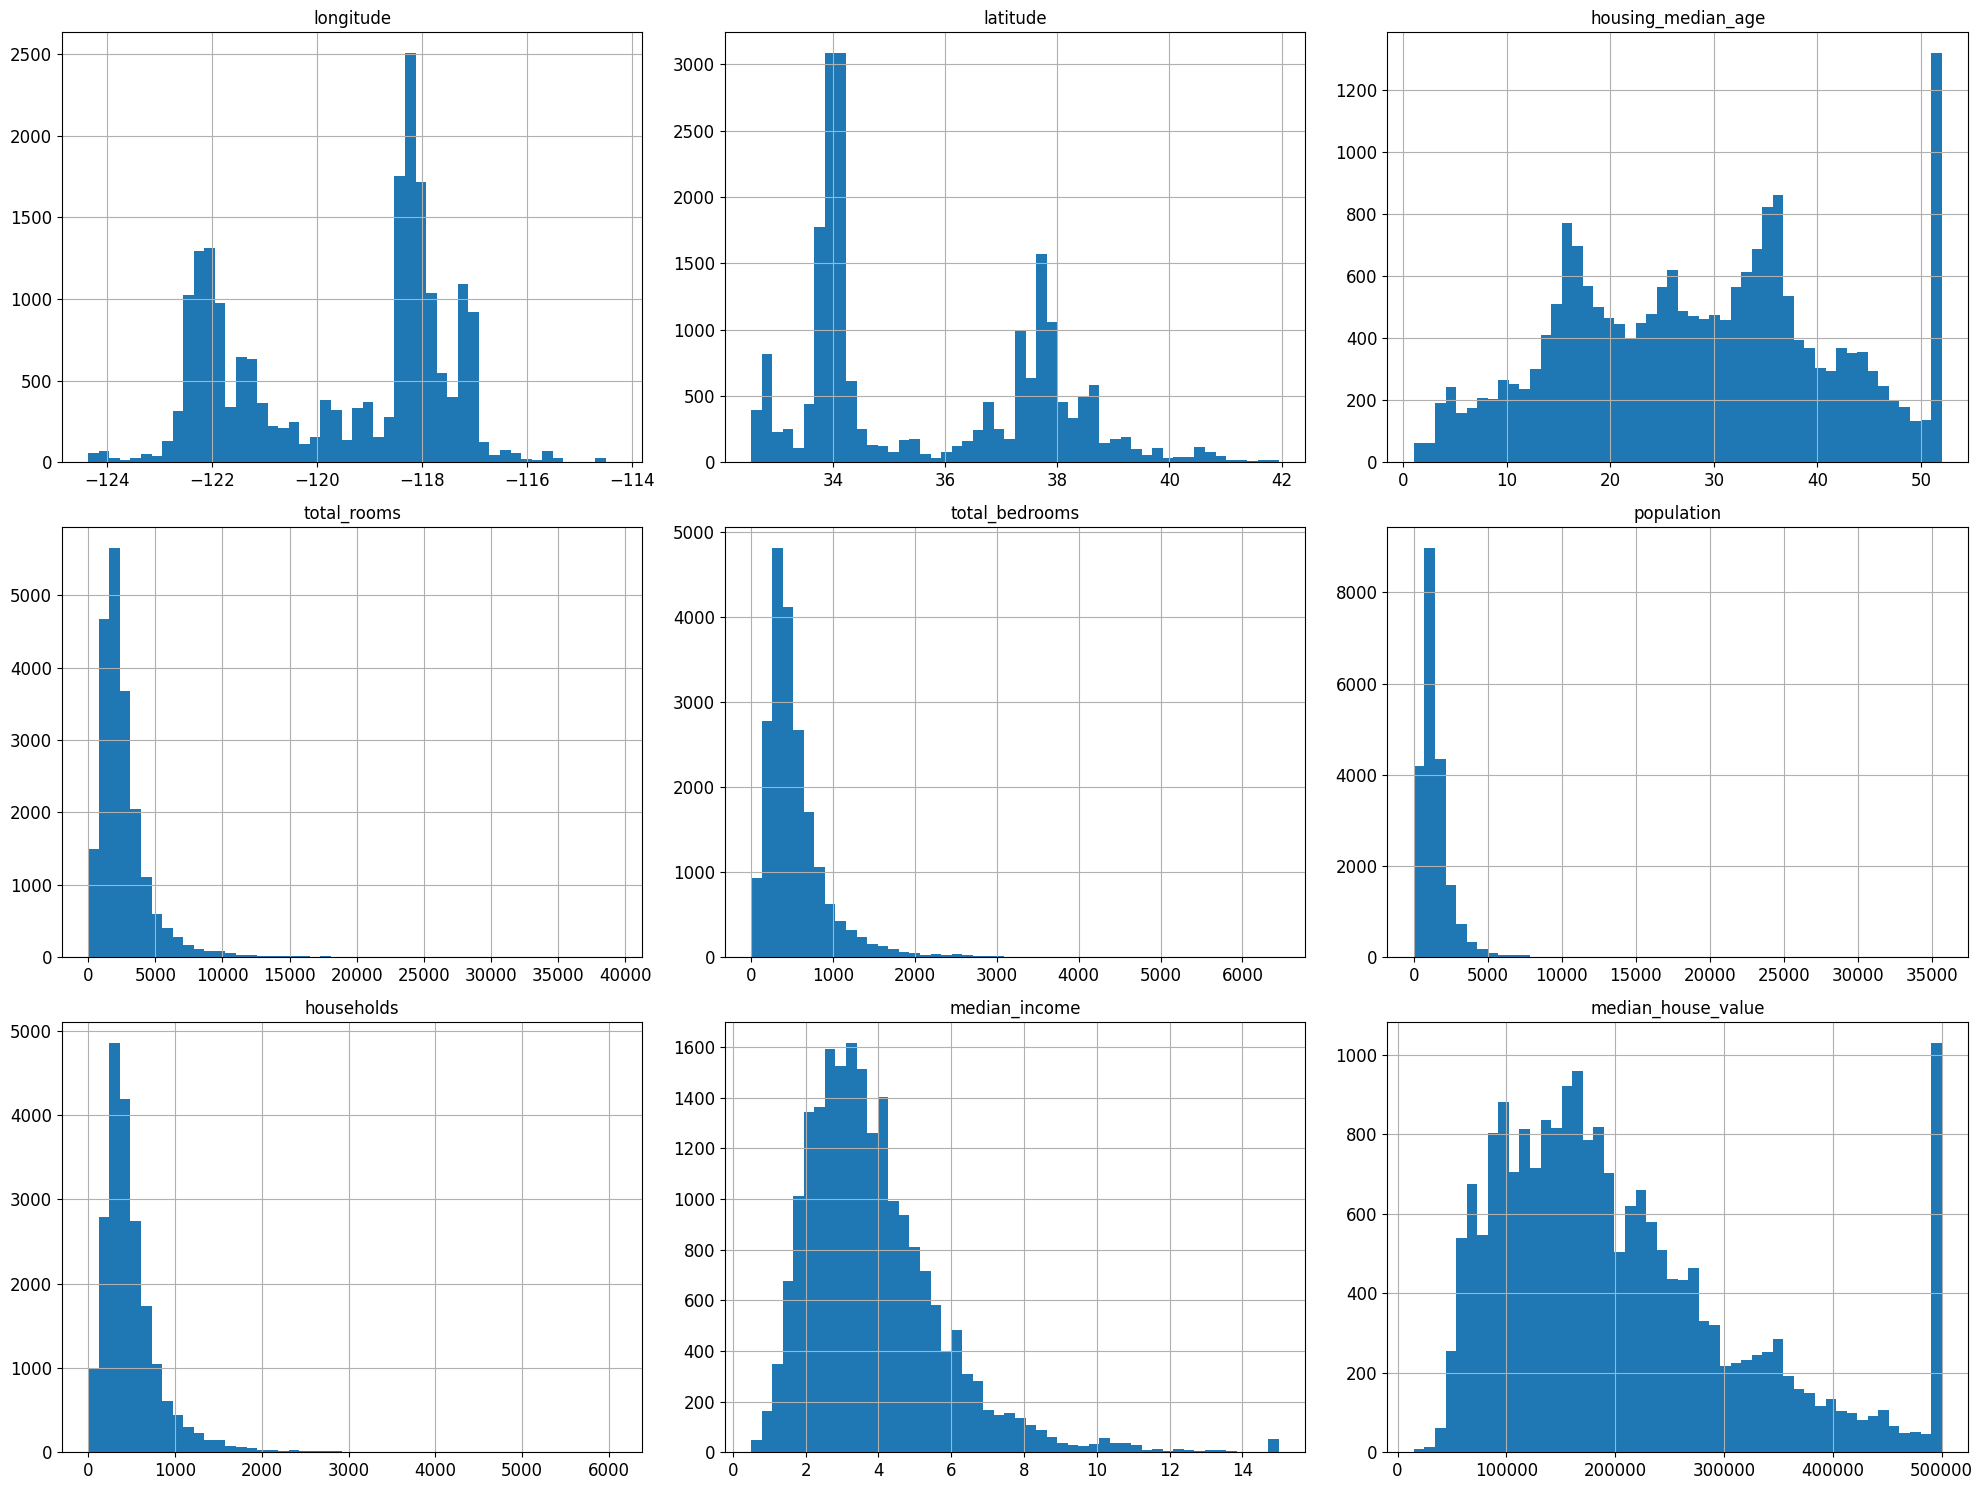

In [9]:
print(os.getcwd())
%matplotlib inline 
# Para adaptarlo al formato del Notebook
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Cosas en las que fijarse.
* La categoría *median_income* está escalada de modo que el valor expresado es en decenas de miles de dolares. Así 5 quiere decir 50.000 dólares
* Las categorías *housing_median_age* y *median_house_value* están truncadas de manera que toda antiguedad superior a 50 se ha incluido en el grupo de 50 años. Lo mismo ocurre con el valor a predecir, el precio mediano en el distrito, que, por encima de 500.000 dolares, está "colapsado" lo que puede ser un problema a la hora de predecir correctamente los precios. Ya veremos como trabajamos con estos datos.

### 2.3 Representación 'geográfica' de los datos.

Aprovechando que tenemos información de la latitud y longitud de los distritos para los que queremos predecir el precio mediano de las viviendas, vamos a representarlos en un mapa.

En una primera versión de la gráfica simplemente representamos en un `scatterplot`, añadiendo el parámetro *alpha = 0.1* que determina la transparencia de los datos. Así si hay zonas con varios puntos aparecerán más marcadas.

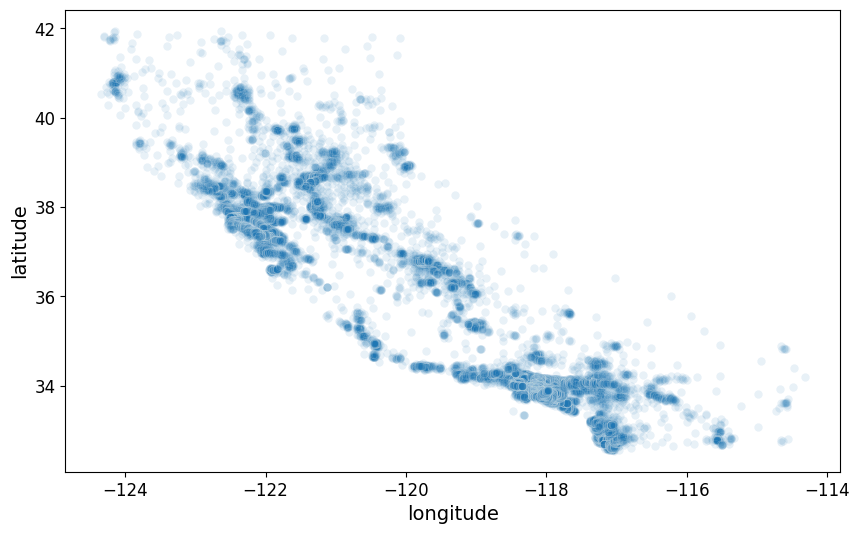

Saving figure mapa_1


<Figure size 640x480 with 0 Axes>

In [14]:
import seaborn as sns

# Crear el gráfico de dispersión con seaborn
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura (opcional)
sns.scatterplot(data=housing, x="longitude", y="latitude", alpha=0.1)

# Mostrar el gráfico
plt.show()
save_fig("mapa_1")

Vamos a mejorar el gráfico. Ahora incluímos:
*  el tamaño de los puntos `s` dependiente de la población total del distrito. 
*  el color `c` basado en la variable a predecir *median_house_value*
*  la transparencia `alpha`.

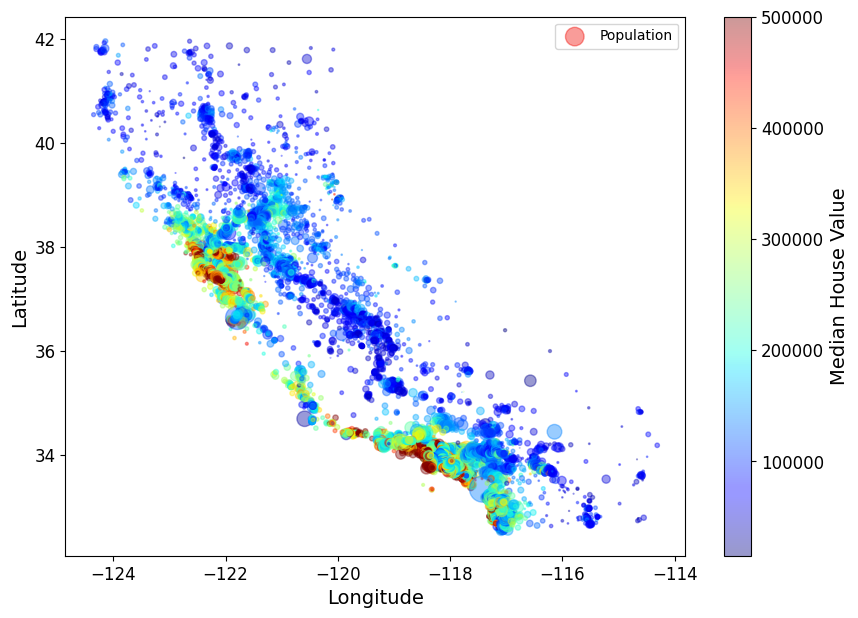

Saving figure mapa_2


<Figure size 640x480 with 0 Axes>

In [15]:
# Configuración del gráfico
plt.figure(figsize=(10, 7))

# Crear el gráfico de dispersión con Seaborn
scatter = plt.scatter(
    housing["longitude"], 
    housing["latitude"], 
    s=housing["population"]/100,           # Tamaño de los puntos
    c=housing["median_house_value"],       # Colorear según median_house_value
    cmap="jet",                            # Colormap jet
    alpha=0.4,                             # Transparencia
)

# Añadir la barra de colores
plt.colorbar(label="Median House Value")

# Añadir etiquetas y leyenda
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(["Population"], loc="upper right")

# Mostrar el gráfico
plt.show()
save_fig("mapa_2")

Por último vamos a ir bastante más allá descargando un mapa de California y usandolo como fondo sobre el que representar los datos.

In [16]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "Imagenes")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./Imagenes/california.png', <http.client.HTTPMessage at 0x137b091f0>)

Saving figure mapa_3


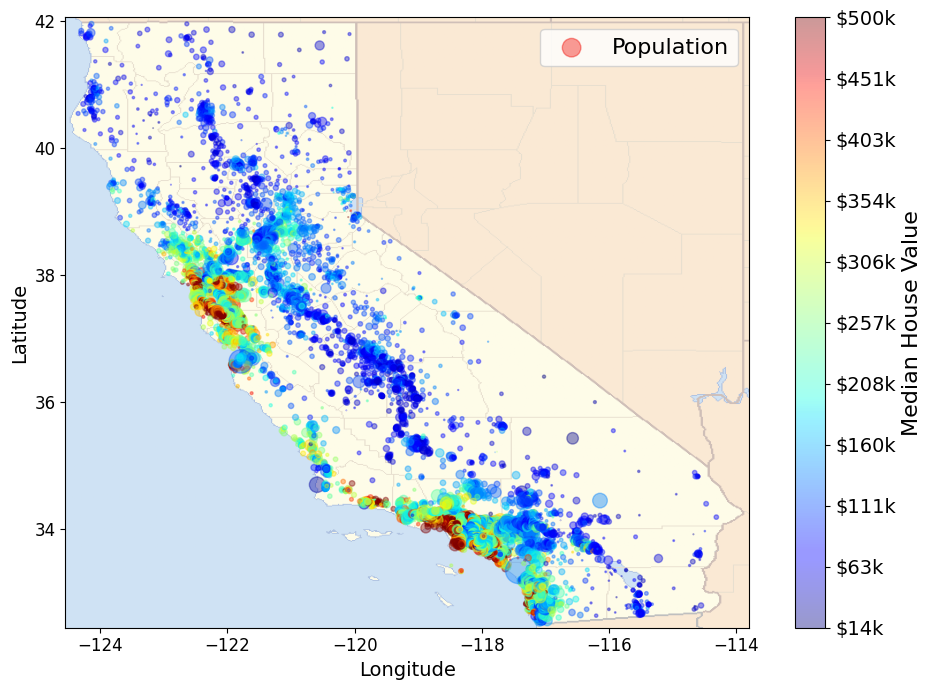

In [17]:
import matplotlib.image as mpimg

# Cargar la imagen de fondo (mapa de California)
california_img = mpimg.imread(os.path.join(IMAGES_PATH, filename))

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 7))

# Dibujar el scatter plot sobre el mapa de California
scatter = plt.scatter(
    housing["longitude"], 
    housing["latitude"], 
    s=housing['population']/100,           # Tamaño de los puntos según la población
    c=housing["median_house_value"],       # Colorear según median_house_value
    cmap="jet",                            # Colormap "jet"
    alpha=0.4                              # Transparencia
)

# Mostrar la imagen de fondo
plt.imshow(
    california_img, 
    extent=[-124.55, -113.80, 32.45, 42.05],  # Extensión geográfica del mapa
    alpha=0.5,                                 # Transparencia de la imagen
    cmap=plt.get_cmap("jet")
)

# Etiquetas de los ejes
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Crear la barra de colores personalizada
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)  # Definir los valores de los ticks
cbar = plt.colorbar(scatter)  # Añadir la barra de colores
cbar.set_ticks(tick_values)   # Establecer los valores de los ticks
cbar.set_ticklabels([f"${int(v/1000)}k" for v in tick_values])  # Formato en miles de dólares
cbar.ax.tick_params(labelsize=14)  # Tamaño de las etiquetas de la barra
cbar.set_label('Median House Value', fontsize=16)

# Añadir leyenda
plt.legend(["Population"], fontsize=16)

# Guardar la figura en el directorio 'Imagenes'
save_fig("mapa_3")

# Mostrar el gráfico
plt.show()



## 3. Análisis Exploratorio de Datos (EDA).

En esta sección vamos a incluir una serie de actuaciones para preparar los datos de cara al modelo de aprendizaje automático. 
Entre otras:

* Buscaremos como correlacionan las variables numericas entre sí. En particular veremos cuales están más relacionadas con la variable que queremos predecir.
* Eliminaremos del análisis aquellas columnas que no aportan información.
* Crearemos características nuevas basadas en las existentes si consideramos que pueden ser útiles. 

### 3.1. Correlación.

Para mostrar la matriz de correlación entre las variables numéricas, necesitas eliminar o ignorar las columnas categóricas como *ocean_proximity*, ya que las correlaciones se calculan entre variables numéricas. Las variables categóricas no pueden participar en el cálculo de la correlación de Pearson (que es el tipo más común), ya que esta mide la relación lineal entre números.

In [18]:
# Eliminar la columna categórica para calcular la correlación
housing_numeric = housing.drop("ocean_proximity", axis=1)

# Calcular la matriz de correlación
corr_matrix = housing_numeric.corr()

# Mostrar la matriz de correlación
corr_matrix


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


De forma mas visual representamos la matriz de correlación en un heatmap utilizando Seaborn.

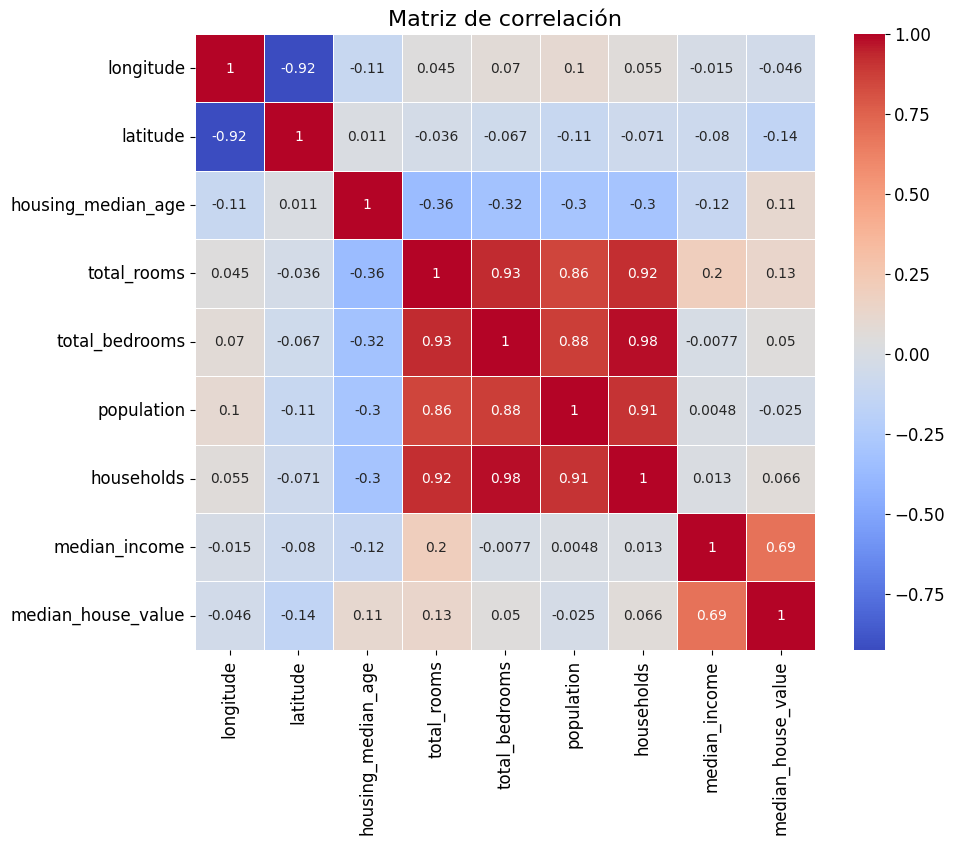

Saving figure correlacion_total


<Figure size 640x480 with 0 Axes>

In [19]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Añadir título
plt.title("Matriz de correlación", fontsize=16)

# Mostrar el gráfico
plt.show()

# Guardar la figura en el directorio 'Imagenes'
save_fig("correlacion_total")

Como la variable que queremos predecir es *median_house_value* vamos a fijarnos como se relaciona cada "característica" con ella.

In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Aparte del 1 de *median_house_value* consigo misma, la característica que parece ser más explicativa del precio mediano por distrito es el salario mediano en el distrito.
Vamos a hacer un `scatterplot` de una frente a otra para explorar mejor la relación existente.   

Fijemonos en la variable más "prometedora" la median_income.

Saving figure income_vs_house_value_scatterplot


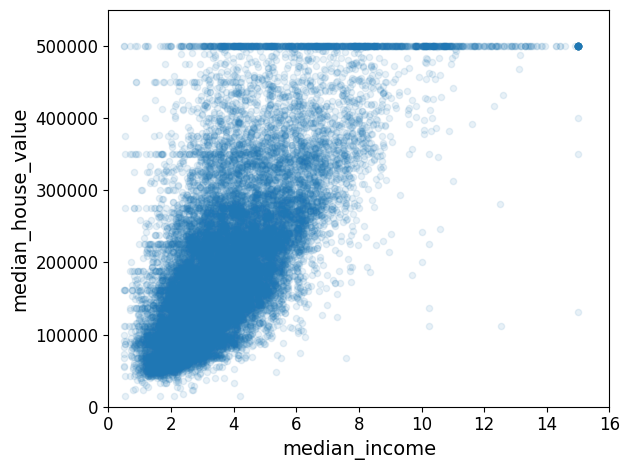

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

Hay una tendencia muy visible por la que el precio mediano de las casas de un barrio crece con el nivel de ingresos de los habitantes del mismo, pero tambien detectamos valores anómalos. Se ve el tope ya comentado en 500.000 dólares, pero también otras tendencias extrañas en 450.000 y 350.000. Quiza queramos eliminar esos distritos anómalos para evitar que nuestro modelo reproduzca información manipulada.

### 3.2. Nuevas características

Entre el conjunto de "features" hay algunas que no tienen sentido por si solas ¿Qué información da el número total de habitaciones en un distrito o el número total de dormitorios? Hemos visto además que su correlación con la variable a predecir es baja. ¿No tiene más sentido expresar esas variables en relación al número de viviendas? Lo mismo ocurre con la población de cada distrito, quizá es más útil saber el número medio de convivientes por casa.

Vamos a añadir 3 columnas a nuestro *DataFrame*:

* *rooms_per_household*: Número medio de estancias por vivienda.
* *bedrooms_per_rooms*: Ratio de dormitorios frente a número de estancias en una vivienda.
* *population_per_household*: Número medio de convivientes por vivienda.

Estas características quizá expliquen mejor el precio mediano de la vivienda en un distrito ya que quiza pueden reflejar mejor si nos encontramos en un barrio densamente poblado, si predominan viviendas unifamiliares o si en las viviendas de un distrito predominan los dormitorios (¿alquileres por habitación?) frente a los espacios comunes.  



In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Veamos si nuestras nuevas variables correlacionan mejor con el *median_house_value*

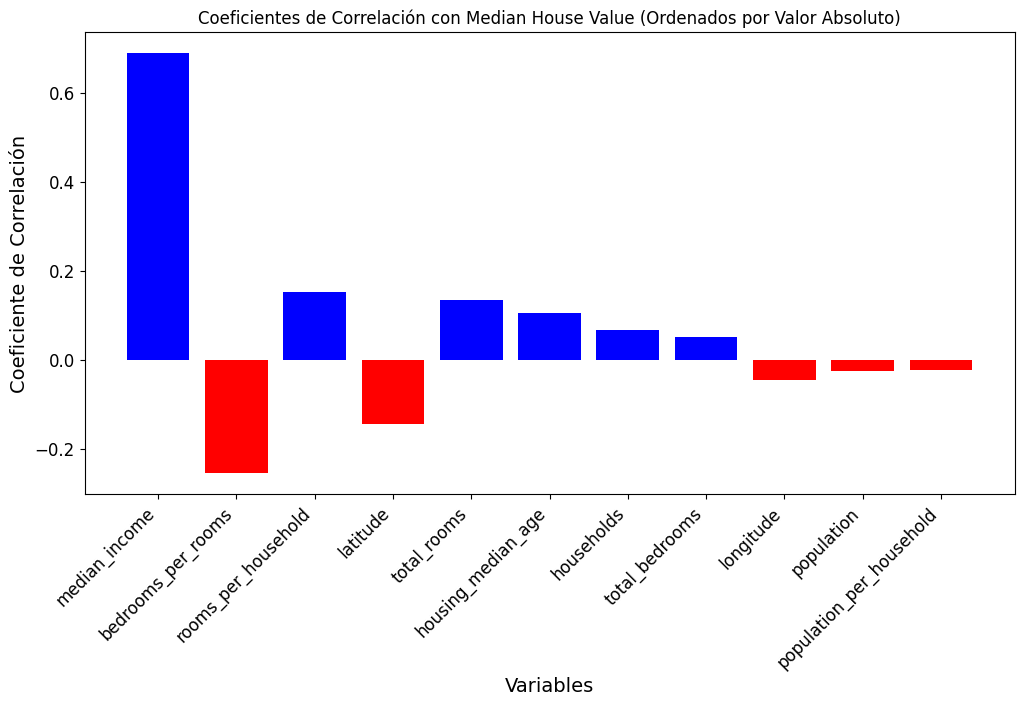

Saving figure new_corr_median_house_value


<Figure size 640x480 with 0 Axes>

In [23]:
# Eliminar la columna categórica para calcular la correlación
housing_numeric = housing.drop("ocean_proximity", axis=1)

# Calcular la matriz de correlación
corr_matrix = housing_numeric.corr()

# Obtener los coeficientes de correlación con 'median_house_value'
corr_with_median_house_value = corr_matrix["median_house_value"]

# Ordenar por valor absoluto
sorted_corr = corr_with_median_house_value.abs().sort_values(ascending=False)
sorted_corr = corr_with_median_house_value.loc[sorted_corr.index]

# Asignar colores basados en el signo del coeficiente
colors = ['red' if val < 0 else 'blue' for val in sorted_corr]

# Crear el gráfico de barras sin pintar la correlación consigo misma
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_corr.index[1:], sorted_corr.values[1:], color=colors[1:])

# Añadir etiquetas y título
plt.xlabel("Variables")
plt.ylabel("Coeficiente de Correlación")
plt.title("Coeficientes de Correlación con Median House Value (Ordenados por Valor Absoluto)")

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()
save_fig("new_corr_median_house_value")

Los resultados parecen tener sentido. Cuanto mayor es el ratio $ \frac{dormitorios}{estancias}$ indica que la vivienda dispone de menos espacios comunes. Eso es más habitual en viviendas que se destinan a alquiler por habitaciones y menos en viviendas unifamiliares. Quizá eso explica la relación negativa entre el precio mediano y el ratio. 

Nuestro *DataFrame* ahora ha cambiado. Veamos la información que ahora contiene.

In [24]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## 4. Preparando los datos para los algoritmos de aprendizaje automático.

### 4.1. Datos Faltantes.

Al principio vimos que no teniamos los valores para *total_bedroom* de todos los barrios. Hay varias posibilidades:

* Eliminar todos los registros donde no tenemos información de esa variable de entrada.
* Eliminar dicha columna ya que hemos visto que no está muy correlacionada con la variable a predecir.
* Imponiendo un valor ficticio que no distorsione mucho los datos, como puede ser la media o la mediana.

(¿Cuál usarías?)

Para ver como hacer cada una de las posibilidades vamos a copiar en un *DataFrame* los registros que no tiene ese dato.


In [25]:
idx = housing['total_bedrooms'].isnull()
idx.sum()

np.int64(207)

In [26]:
sample_incomplete_rows = housing[idx].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,population_per_household
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


La opción 1 es eliminar dichos registros.
En el código si quisieras usar esta opción sobre el *DataFrame* real pondríamos:
```python
housing_clean_1 = housing.dropna(subset=['total_bedrooms'])
```
o 
```python
idx = housing['total_bedrooms'].isnull()
housing_clean_1 = housing[~idx] 
```
o 
```python
idx = housing['total_bedrooms'].notnull()
housing_clean_1 = housing[idx] 
```

In [27]:
idx = housing['total_bedrooms'].notnull()
housing_clean_1 = housing[idx]
housing_clean_1.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,5.431344,0.213039,3.071533
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,2.482946,0.057983,10.438269
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,4.441441,0.175427,2.429032
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,5.230769,0.203162,2.817582
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,6.052381,0.239821,3.281513
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


La opción 2 es eliminar dicha característica de todos los registros.
En el código si quisieras usar esta opción sobre el *DataFrame* real pondríamos:
```python
housing_clean_2 = housing.drop("total_bedrooms", axis=1) 
```

In [28]:
housing_clean_2 = housing.drop("total_bedrooms", axis=1)
housing_clean_2.describe()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


Por último la opción 3 es rellenar en todos los registros donde falte esa información el valor mediano (El valor medio se podría ver afectado por valores anómalos incorrectos).
```python 
# Calcular la mediana de 'total_bedrooms'
median_total_bedrooms = housing['total_bedrooms'].median()

# Crear un nuevo DataFrame y rellenar los valores nulos en 'total_bedrooms' con la mediana
housing_clean_3 = housing.copy()
housing_clean_3['total_bedrooms'] = housing['total_bedrooms'].fillna(median_total_bedrooms)
``` 

In [29]:
# Calcular la mediana de 'total_bedrooms'
median_total_bedrooms = housing['total_bedrooms'].median()

# Crear un nuevo DataFrame y rellenar los valores nulos en 'total_bedrooms' con la mediana
housing_clean_3 = housing.copy()
housing_clean_3['total_bedrooms'] = housing['total_bedrooms'].fillna(median_total_bedrooms)

housing_clean_3.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


Vamos a escoger esta última opción.
Debemos fijarnos que la caracteristica creada *bedrooms_per_room* depende del valor de *total_bedrooms*. Así que también tiene valores nulos que debemos rellenar.

In [30]:
# Calcular la mediana de 'total_bedrooms'
median_total_bedrooms = housing['total_bedrooms'].median()
median_bedrooms_per_room = housing['bedrooms_per_rooms'].median()

# Crear un nuevo DataFrame y rellenar los valores nulos en 'total_bedrooms' y 'bedrooms_per_room' con la mediana
housing_clean = housing.copy()
housing_clean['total_bedrooms'] = housing['total_bedrooms'].fillna(median_total_bedrooms)
housing_clean['bedrooms_per_rooms'] = housing['bedrooms_per_rooms'].fillna(median_bedrooms_per_room)

housing_clean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.212940,3.070655
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057700,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175708,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239273,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


### 4.2. Estandarizar/Escalar los datos de entrada. 

En el preprocesamiento de datos para el aprendizaje automático es importante que todas las características están en escalas parecidas para evitar que su importancia en el modelo se sobre o infravalore. Hay diferentes maneras de hacerlo, aquí vamos a usar Z-Score Standard Scaler que ajusta la característica restando su media y dividiendo por la desviación estándar.

De un modo práctico voy a definir una función que reciba un *DataFrame* y el conjunto de columnas que **no** quiero estandarizar. Este argumento lo voy a usar porque la variable a predecir *median_house_value* no la vamos a escalar ya que nos puede dificultar interpretar los resultados.

In [31]:
from sklearn.preprocessing import StandardScaler

def standardize_dataframe(df, column_names):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number])

    # Exclude the columns specified in column_names
    numerical_cols_to_standardize = numerical_cols.drop(columns=column_names)

    # Standardize numerical columns
    scaler = StandardScaler()
    scaled_numerical_cols = scaler.fit_transform(numerical_cols_to_standardize)
    df[numerical_cols_to_standardize.columns] = scaled_numerical_cols

    return df
housing_stand = standardize_dataframe(housing_clean.copy(),["median_house_value"])
housing_stand.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,20640.000000,2.064000e+04,2.064000e+04,2.064000e+04
mean,-8.526513e-15,-1.079584e-15,5.508083e-18,3.201573e-17,-9.363741e-17,-1.101617e-17,6.885104e-17,6.609700e-17,206855.816909,6.609700e-17,-3.580254e-16,3.442552e-18
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,115395.615874,1.000024e+00,1.000024e+00,1.000024e+00
min,-2.385992e+00,-1.447568e+00,-2.196180e+00,-1.207283e+00,-1.277688e+00,-1.256123e+00,-1.303984e+00,-1.774299e+00,14999.000000,-1.852319e+00,-1.957424e+00,-2.290000e-01
25%,-1.113209e+00,-7.967887e-01,-8.453931e-01,-5.445698e-01,-5.718868e-01,-5.638089e-01,-5.742294e-01,-6.881186e-01,119600.000000,-3.994496e-01,-6.452881e-01,-6.171062e-02
50%,5.389137e-01,-6.422871e-01,2.864572e-02,-2.332104e-01,-2.428309e-01,-2.291318e-01,-2.368162e-01,-1.767951e-01,179700.000000,-8.078489e-02,-1.694568e-01,-2.431585e-02
75%,7.784964e-01,9.729566e-01,6.643103e-01,2.348028e-01,2.537334e-01,2.644949e-01,2.758427e-01,4.593063e-01,264725.000000,2.519615e-01,4.563910e-01,2.037453e-02
max,2.625280e+00,2.958068e+00,1.856182e+00,1.681558e+01,1.408779e+01,3.025033e+01,1.460152e+01,5.858286e+00,500001.000000,5.516324e+01,1.364099e+01,1.194191e+02


Fijate en los valores de la media para todas las variables numéricas son 0 (e-15 es computacionalmente 0) salvo para la variable a predecir.

Ahora *`housing_stand`* es el *DataFrame* con las variables de entrada escaladas y sin datos faltantes.

In [32]:
housing_stand.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,population_per_household
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,452600.0,NEAR BAY,0.628559,-1.149930,-0.049597
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,358500.0,NEAR BAY,0.327041,-0.990381,-0.092512
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,352100.0,NEAR BAY,1.155620,-1.445865,-0.025843
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,341300.0,NEAR BAY,0.156966,-0.493627,-0.050329
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,342200.0,NEAR BAY,0.344711,-0.707889,-0.085616


### 4.3. Manejando variables categóricas.

Vamos a preprocesar la variable categórica *ocean_proximity*. Para jugar con ella voy a crear un *DataFrame* que contenga solamente 3 columnas: 2 numéricas: *median_income* y la variable a predecir *median_house_value* y, por otro lado, la variable categórica *ocean_proximity*.

In [33]:
housing_cat = housing[["median_income","median_house_value","ocean_proximity"]]
housing_cat.head(10)

,median_income,median_house_value,ocean_proximity
0,8.3252,452600.0,NEAR BAY
1,8.3014,358500.0,NEAR BAY
2,7.2574,352100.0,NEAR BAY
3,5.6431,341300.0,NEAR BAY
4,3.8462,342200.0,NEAR BAY
5,4.0368,269700.0,NEAR BAY
6,3.6591,299200.0,NEAR BAY
7,3.1200,241400.0,NEAR BAY
8,2.0804,226700.0,NEAR BAY
9,3.6912,261100.0,NEAR BAY


#### Label Encoding.
Una posibilidad de codificar los valores de texto de forma numérica es simplemente asignarle a cada uno de ellos un número. 

In [34]:
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Create a label encoder
encoder = LabelEncoder()

# Encode the categorical variable
housing_cat_encoded = encoder.fit_transform(housing_cat["ocean_proximity"])

# Combine the encoded column with the original DataFrame (excluding ocean_proximity)
housing_cat_encoded = pd.DataFrame({'ocean_proximity': housing_cat_encoded})
housing_cat_full = pd.concat([housing_cat[["median_income", "median_house_value"]], housing_cat_encoded], axis=1)

# Print the full DataFrame
print(housing_cat_full)

       median_income  median_house_value  ocean_proximity
0             8.3252            452600.0                3
1             8.3014            358500.0                3
2             7.2574            352100.0                3
3             5.6431            341300.0                3
4             3.8462            342200.0                3
...              ...                 ...              ...
20635         1.5603             78100.0                1
20636         2.5568             77100.0                1
20637         1.7000             92300.0                1
20638         1.8672             84700.0                1
20639         2.3886             89400.0                1

[20640 rows x 3 columns]


In [35]:
housing_cat_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_income       20640 non-null  float64
 1   median_house_value  20640 non-null  float64
 2   ocean_proximity     20640 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 483.9 KB


Hemos convertido la variable categórica en una numérica. El problema es que al trabajar con números damos por hecho que el '0' está más cerca del '1' que del '4'. En este caso '0' correspode a las viviendas que cumplen *<1H OCEAN* que suponemos que deberían estar más cerca de las viviendas codificadas como '4' *NEAR OCEAN* que de aquellas codificadas con '1' *INLAND*.

#### One-Hot Encoding 
Para evitar que el modelo asuma que existe un orden en la variable *ocean_proximity* usamos un codificador que no genere un orden artificial en variables categóricas, el `One-Hot Encoding`.

De nuevo, de modo práctico voy a definir una función que reciba un *DataFrame* y el conjunto de columnas categóricas que quiero codificar. Devolverá el *DataFrame* con las columnas codificadas usando la estrategia `One-Hot Encoding`

In [36]:
from sklearn.preprocessing import OneHotEncoder

def onehot_dataframe(df, column_names):
    categorical_cols = df[column_names]
    encoder = OneHotEncoder()
    encoder.fit(categorical_cols)
    encoded_data = encoder.transform(categorical_cols)
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(column_names))
    df = df.drop(columns=column_names)
    df.reset_index(drop=True, inplace=True)
    df_encoded = pd.concat([df, encoded_df], axis=1)
    return df_encoded

housing_encoded = onehot_dataframe(housing_cat.copy(),["ocean_proximity"])
housing_encoded.head()

,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


Ahora que lo hemos probado en un mini *DataFrame* vamos a emplear esa estrategia para codificar la variable categorica del conjunto de datos previamente estandarizado *`housing_stand`*.

In [37]:
housing_stand_1hotcoded = onehot_dataframe(housing_stand.copy(),["ocean_proximity"])

In [38]:
housing_stand_1hotcoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,452600.0,0.628559,-1.149930,-0.049597,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,358500.0,0.327041,-0.990381,-0.092512,0.0,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,352100.0,1.155620,-1.445865,-0.025843,0.0,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,341300.0,0.156966,-0.493627,-0.050329,0.0,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,342200.0,0.344711,-0.707889,-0.085616,0.0,0.0,0.0,1.0,0.0


## 5. División del conjunto de datos en Training y Test.

El *Train-Test Split* es una técnica que consiste en dividir el conjunto de datos disponibles en dos subconjuntos: uno para el entrenamiento del modelo (Train Set) y otro para la evaluación del mismo (Test Set). 
Lo primero que voy a hacer por simplicidad es renombrar la base de datos.

In [39]:
housing_prepared = housing_stand_1hotcoded.copy()

Vamos a seguir dos estrategias:

* La más sencilla: dividimos el conjunto usando la partición habitual 80-20%

* **Opcional** Vamos a hacer la división garantizando que los datos en los conjuntos de Test y Training se distribuyen en la misma proporción que en la variable más representativa *median_house_value* 

### Holdout 80-20% 

In [40]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_prepared, test_size=0.2, random_state=42)

In [41]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
20046,0.279366,0.200449,-0.289187,-0.518327,-0.242831,-0.029562,-0.367597,-1.152489,47700.0,-0.499896,-0.169457,0.077681,0.0,1.0,0.0,0.0,0.0
3024,0.054757,-0.230283,0.108104,0.140833,-0.242831,0.123206,0.220915,-0.705015,45800.0,-0.157477,-0.169457,-0.037634,0.0,1.0,0.0,0.0,0.0
15663,-1.432653,1.015093,1.856182,0.547423,-0.242831,-0.101972,1.212230,-0.205588,500001.0,-0.586814,-0.169457,-0.164679,0.0,0.0,0.0,1.0,0.0
20484,0.424114,-0.632923,-0.924851,0.190339,-0.242831,0.246834,-0.011874,0.982710,218600.0,0.296929,-0.169457,0.035990,1.0,0.0,0.0,0.0,0.0
9814,-1.178096,0.462633,0.425936,-0.130532,-0.242831,-0.320086,-0.187120,-0.076678,278000.0,0.025864,-0.169457,-0.056520,0.0,0.0,0.0,0.0,1.0


### Opcional

¿Cómo podemos asegurarnos de que nuestra división *train/test* es representativa respecto al conjunto original? 
Por ejemplo, con todo lo que hemos visto hasta ahora sabemos que la variable que más correlaciona con la variable a predecir es *median_income*. Nos gustaría que los datos en *train* se distribuyeran de la misma manera que el conjunto original respecto a sus valores de *median_income*

<Axes: >

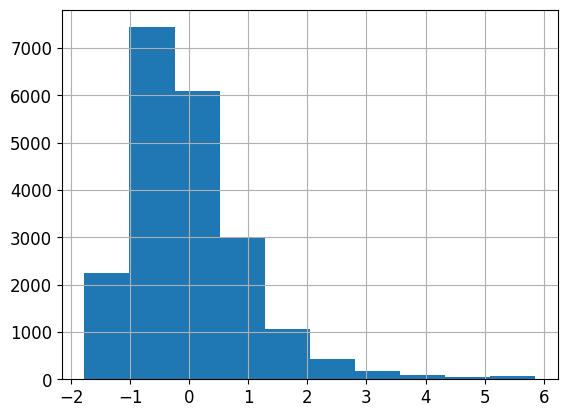

In [42]:
housing_prepared["median_income"].hist()

En valores estandarizados vemos que la distribución esta sesgada a la izquierda. Creamos una nueva variable de entrada donde agrupamos con etiquetas los grupos mas representativos de la variable *median_income*. Los grupos serán: [-2.,-1.], [-1., 0.], [0.,1.], [1.,2.], [2.,$\infty$] etiquetadas del 1 al 5.

In [43]:
housing_prepared["income_cat"] = pd.cut(housing_prepared["median_income"],
                               bins=[-2., -1., 0., 1., 2., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [44]:
housing_prepared["income_cat"].describe()

count     20640
unique        5
top           2
freq       9682
Name: income_cat, dtype: int64

In [45]:
housing_prepared["income_cat"].value_counts()

income_cat
2    9682
3    5978
1    2322
4    1807
5     851
Name: count, dtype: int64

<Axes: >

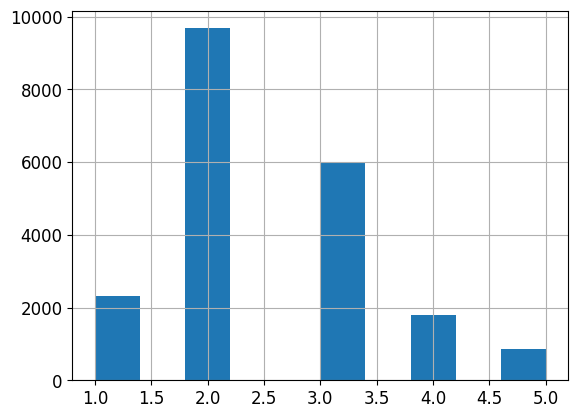

In [46]:
housing_prepared["income_cat"].hist()

Sabiendo que el conjunto de datos de entrada se reparten de esta manera respecto a la variable *median_income* lo que queremos es que los datos de entrenamiento *train* mantengan esta proporción. Sería algo asi como en cada grupo de income_cat hacer un train/test al 80%-20%

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_prepared, housing_prepared["income_cat"]):
    strat_train_set = housing_prepared.loc[train_index]
    strat_test_set = housing_prepared.loc[test_index]

In [48]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
2    0.468992
3    0.289729
1    0.112403
4    0.087694
5    0.041182
Name: count, dtype: float64

Este es el porcentaje de registros del nuevo *train* en cada una de los subconjuntos de *median_income*.
Calculemos lo mismo para los datos originales.

In [49]:
housing_prepared["income_cat"].value_counts() / len(housing_prepared)

income_cat
2    0.469089
3    0.289632
1    0.112500
4    0.087548
5    0.041231
Name: count, dtype: float64

Perfecto!

Veamos si nuestra división original en entrenamiento y test respetaba esa proporción.

In [50]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_prepared, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing_prepared),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.112500,0.112403,0.115795,2.928510,-0.086133
2,0.469089,0.468992,0.475533,1.373683,-0.020657
3,0.289632,0.289729,0.286822,-0.970224,0.033456
4,0.087548,0.087694,0.081153,-7.304925,0.166021
5,0.041231,0.041182,0.040698,-1.292597,-0.117509


Como vemos no es tan preciso. Así que a partir de ahora usaremos la división *train/test* respetuoso con los porcentajes de la categoría *median_income*.
Eliminamos del nuevo *train/test* la categoria artificial que creamos antes

In [51]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [52]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_rooms,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
358,-1.282913,1.001048,-0.130270,-0.186455,-0.409743,-0.113452,-0.378059,0.505180,279100.0,0.343506,-0.852527,0.056121,0.0,0.0,0.0,1.0,0.0
8160,0.718601,-0.852971,0.664310,-0.645300,-0.714955,-0.753665,-0.673622,0.239149,223900.0,-0.143332,-0.345644,-0.068076,1.0,0.0,0.0,0.0,0.0
13150,-0.948496,0.603089,-0.130270,-0.268965,-0.285751,-0.172616,-0.427755,0.409011,265900.0,0.270487,-0.163365,0.056814,0.0,1.0,0.0,0.0,0.0
18727,-1.392722,2.307288,-0.686477,0.438327,0.789641,0.388122,0.736189,-0.971099,64800.0,-0.335380,0.497560,-0.065733,0.0,1.0,0.0,0.0,0.0
4496,0.673679,-0.740606,0.425936,-0.698015,-0.242831,-0.439298,-0.548073,-0.371239,155000.0,-0.643086,-0.169457,0.012454,1.0,0.0,0.0,0.0,0.0


In [53]:
train_set = strat_train_set
test_set  = strat_test_set

### Fin de la parte opcional

## 6. Regresión Lineal usando SKLearn 

Lo primero que haremos será dividir los datos en variables de entrada y la salida que queremos predecir.


In [54]:
housing_input = train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = train_set["median_house_value"].copy()

### 6.1. Entrenamiento y evaluación en el conjunto de datos de entrenamiento.

Generamos el modelo de regresión lineal y lo entrenamos.

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_input, housing_labels)

LinearRegression()

Veamos como funciona en datos de entrenamiento


In [56]:
some_data = housing_input.iloc[:5]
some_labels = housing_labels.iloc[:5]

print("Predictions:", lin_reg.predict(some_data))

Predictions: [241680.95813313 246990.93133625 218684.82963832  69066.78539651
 183601.45632884]


Comparamos con los precios reales

In [57]:
print("Labels:", list(some_labels))

Labels: [279100.0, 223900.0, 265900.0, 64800.0, 155000.0]


Obtengamos métricas del error

In [58]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_input)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(67653.35957955112)

In [59]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

48857.31607031309

¿Que significan esos valores? 
Vamos a usar un gráfico de dispersión para ver mejor como se comporta el modelo.

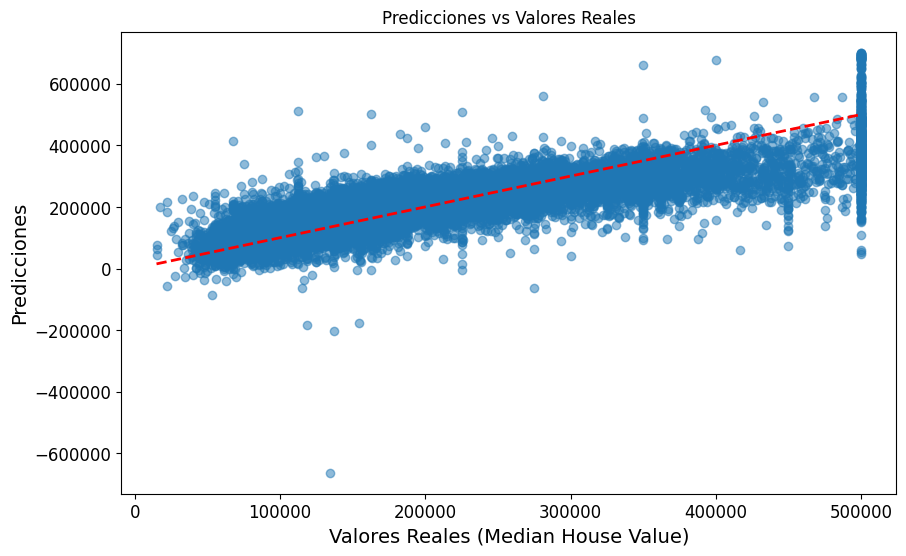

In [60]:

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.5)

# Añadir línea de referencia y etiquetas
plt.plot([housing_labels.min(), housing_labels.max()], [housing_labels.min(), housing_labels.max()], "r--", lw=2)  # Línea de referencia y=y
plt.xlabel("Valores Reales (Median House Value)")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")

# Mostrar el gráfico
plt.show()

Los resultados pueden ser bastante decepcionantes. El error cometido por el modelo es muy grande. Pero ten en cuenta que no hemos "limpiado" completamente los datos. Por ejemplo no hemos considerado que los datos están colapsados por encima de 500000$. Además la regresión lineal puede no ser el mejor modelo para trabajar con este conjunto de datos. La hemos empleado por simplicidad.

Prueba a repetir los cálculo pero eliminando de los datos originales los distritos donde la variable `median_house_value` toma valor $ \geq 500000$